In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('climate_nasa.csv')

# Checking the data
print(data.head())


                       date  likesCount  \
0  2022-09-07T17:12:32.000Z           2   
1  2022-09-08T14:51:13.000Z           0   
2  2022-09-07T17:19:41.000Z           1   
3  2022-09-08T00:51:30.000Z           4   
4  2022-09-07T19:06:20.000Z          16   

                                         profileName  commentsCount  \
0  4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...            NaN   
1  518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...            NaN   
2  d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...            3.0   
3  37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...            NaN   
4  e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...           26.0   

                                                text  
0  Neat comparison I have not heard it before.\r\...  
1  An excellent way to visualise the invisible! T...  
2  Does the CO2/ghg in the troposphere affect the...  
3  excellent post! I defo feel the difference - o...  
4  Yes, and carbon dioxide does not har

In [2]:
# Handle Missing Data - Fill missing values in 'text' column with an empty string
data['text'] = data['text'].fillna('')

# Handle Duplicates
duplicates = data.duplicated().sum()
if duplicates > 0:
    print(f'Duplicates found: {duplicates}')
    data = data.drop_duplicates()

# Prepare the data for predicting likes
X = data['text']  # Feature is the text (user comments)
y = data['likesCount']  # Target is likesCount

# Convert text data into numerical features using TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize the features (with with_mean=False for sparse matrix)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Best Model from GridSearch
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


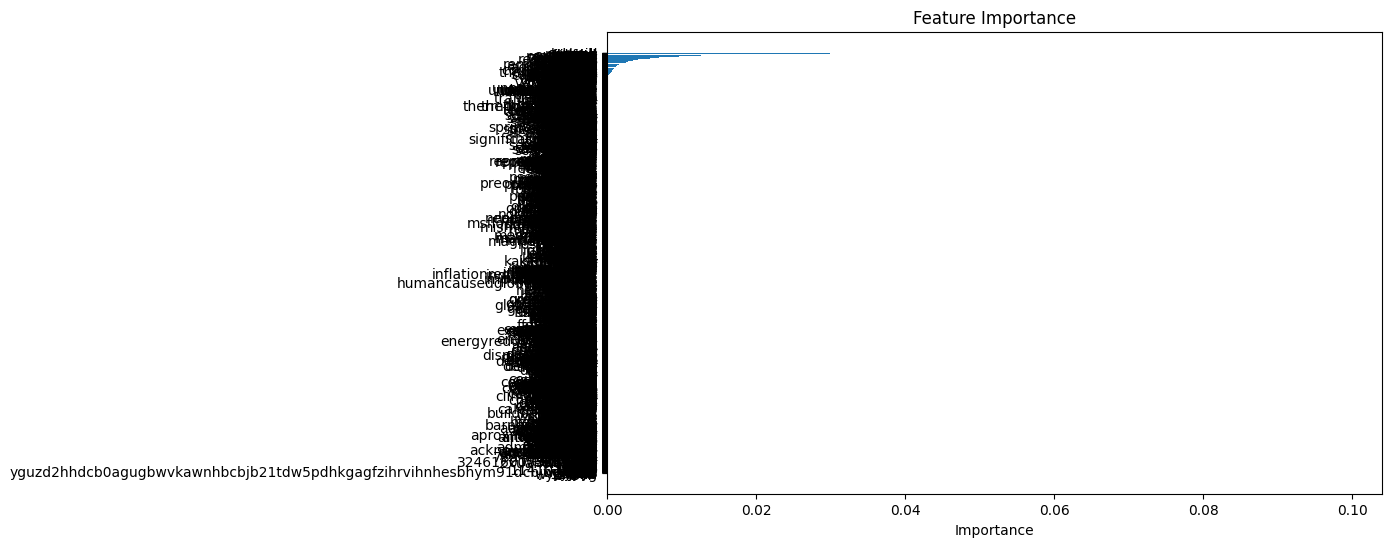

In [5]:
# Extract feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get feature importances
feature_importances = best_model.feature_importances_

# Sort feature importances
sorted_idx = feature_importances.argsort()

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()


In [6]:

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f'Mean Cross-Validation MAE: {-cv_scores.mean()}')


Mean Cross-Validation MAE: 5.344264382304037


Mean Absolute Error: 543032.6972585296
Mean Squared Error: 11917536955612.635
R-squared: -66329867650.90512


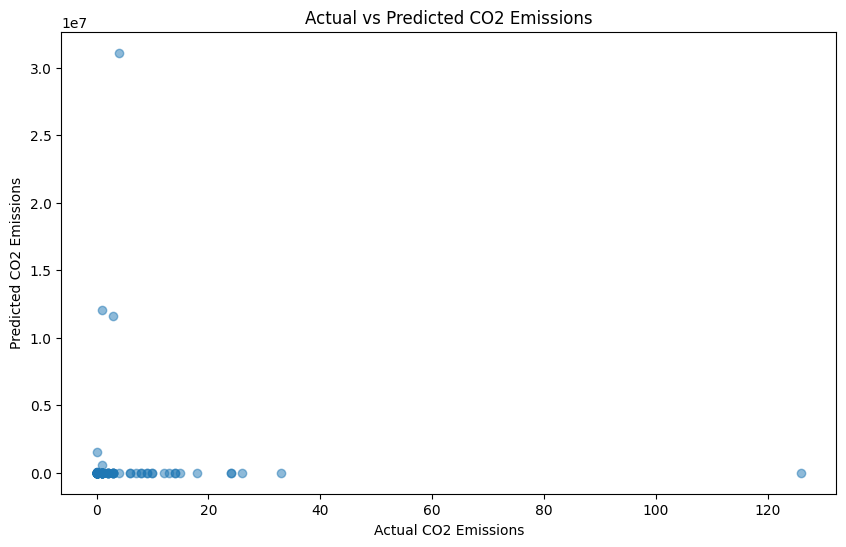

In [7]:

# Model Evaluation - Actual vs Predicted
y_pred_log = best_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # Reverse the log transformation

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Actual vs Predicted CO2 Emissions')
plt.show()


Mean Absolute Error: 543032.6972585296
Mean Squared Error: 11917536955612.635
R-squared: -66329867650.90512


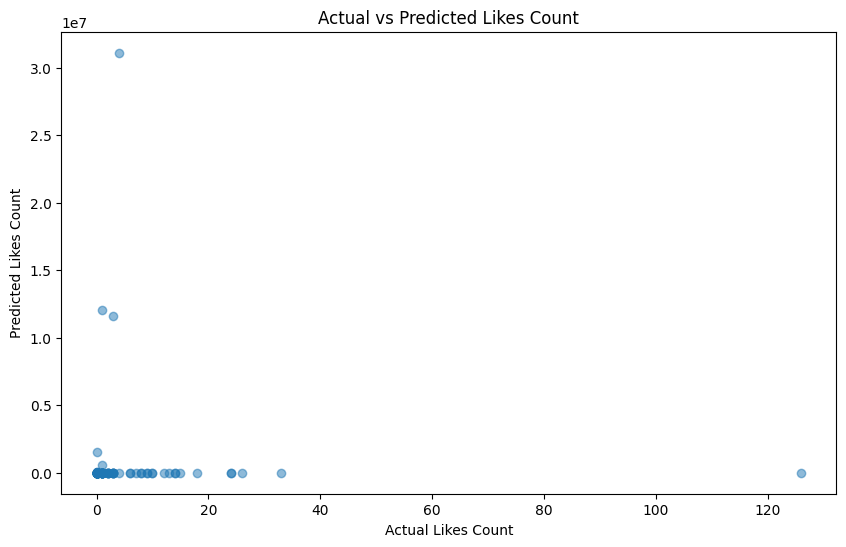

Model saved as 'model.pkl'


In [10]:
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Model Evaluation - Actual vs Predicted
y_pred_log = best_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # Reverse the log transformation

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Likes Count')
plt.ylabel('Predicted Likes Count')
plt.title('Actual vs Predicted Likes Count')
plt.show()

# Save the trained model using joblib
joblib.dump(best_model, 'model.pkl')
print("Model saved as 'model.pkl'")


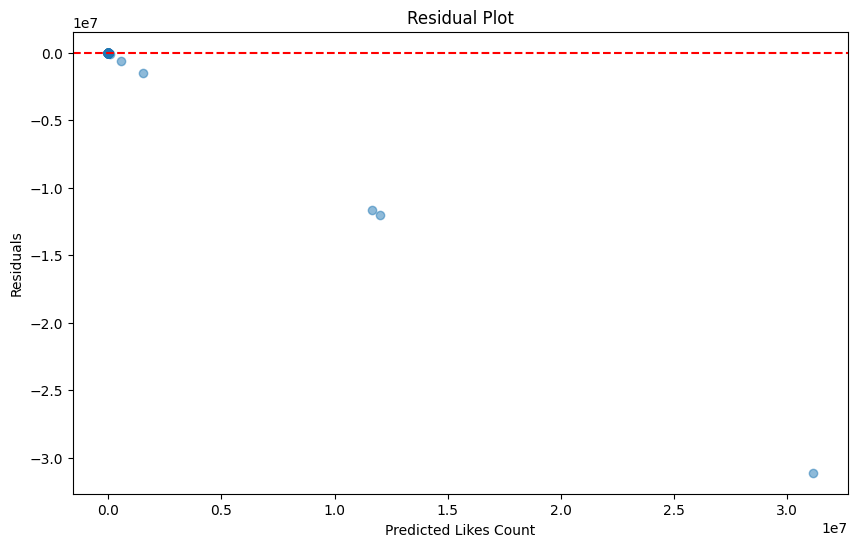

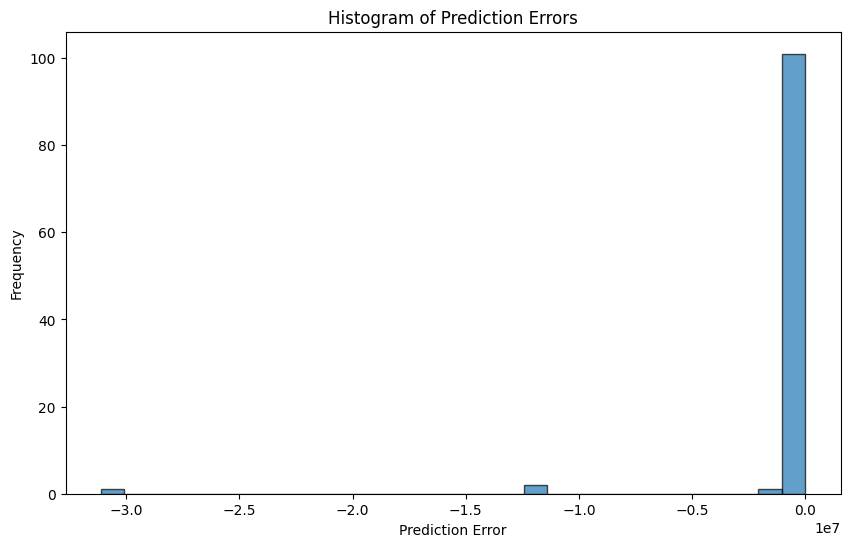

In [11]:
# 2. Residual Plot (Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Zero error line
plt.xlabel('Predicted Likes Count')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# 3. Error Histogram
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()